In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dists
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d
from torch_utils import get_limits, visualise_tension, visualise_coordinate, plot_marginalised_dists
from np_utils import simple_data
from tension_net import TensionNet
from tension_quantify import BayesFactor, SuspiciousnessKLDiv, LogSuspiciousness

In [2]:
X0, X1, X_prior = simple_data()
X0_tensor = torch.tensor(X0, dtype=torch.float)
X1_tensor = torch.tensor(X1, dtype=torch.float)
X_prior_tensor = torch.tensor(X_prior, dtype=torch.float)

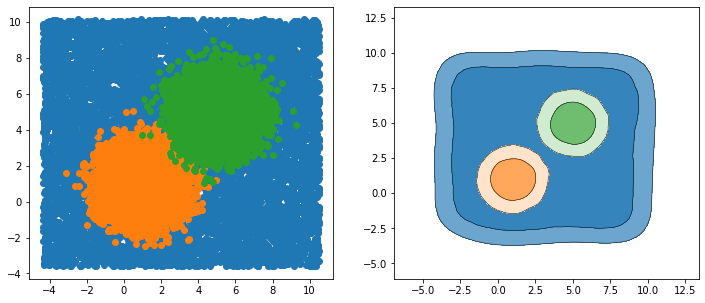

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(X_prior[:, 0], X_prior[:, 1])
axs[0].scatter(X0[:, 0], X0[:, 1])
axs[0].scatter(X1[:, 0], X1[:, 1])
kde_contour_plot_2d(axs[1], X_prior[:, 0], X_prior[:, 1])
kde_contour_plot_2d(axs[1], X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs[1], X1[:, 0], X1[:, 1])
plt.show()

## Visualising the contours of combined likelihood L_{AB}

In [4]:
tension = TensionNet(2)
theta = np.pi / 4
max_n = torch.tensor([np.cos(theta), np.sin(theta)])
tension.state_dict()["linear.weight"].copy_(max_n)
tension.state_dict()["linear.bias"].copy_(torch.tensor([0]))

tensor([0.])

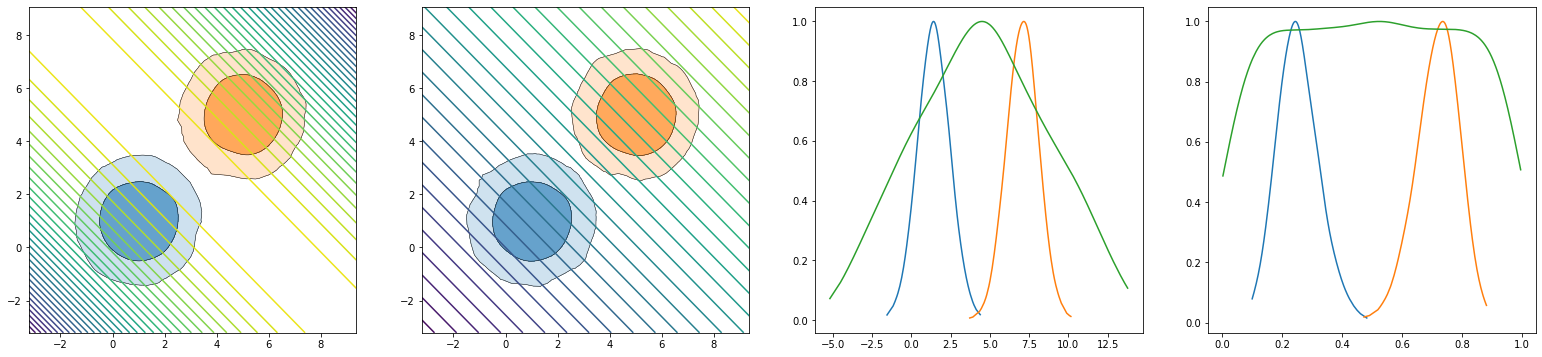

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(27, 6))
visualise_tension(fig, axs[0], tension, X0, X1)
visualise_coordinate(fig, axs[1], tension,X0, X1)
X0_1d = tension(X0_tensor).squeeze().detach().numpy()
X1_1d = tension(X1_tensor).squeeze().detach().numpy()
X_prior_1d = tension(X_prior_tensor).squeeze().detach().numpy()

plot_marginalised_dists(fig, axs[2], X0_1d, X1_1d, X_prior_1d, flat_prior=False)
plot_marginalised_dists(fig, axs[3], X0_1d, X1_1d, X_prior_1d, flat_prior=True)

In [68]:
def visualise_tension(fig, axs, tension_net, XA, XB):
    XA_tensor = torch.tensor(XA).float()
    XB_tensor = torch.tensor(XB).float()
    XA_1d = tension_net(XA_tensor)
    XB_1d = tension_net(XB_tensor)
    X_combine = torch.cat((XA_1d, XB_1d))

    def likelihood_f(z, X, cov=torch.tensor(1).float()):
        normal = dists.Normal(z.float(), cov)
        return normal.log_prob(X).sum(0)

    bounds_A = get_limits(XA_tensor)
    bounds_B = get_limits(XB_tensor)
    bounds = torch.cat((bounds_A, bounds_B), dim=1)
    low_lims = bounds.min(1).values
    up_lims = bounds.max(1).values

    x = torch.linspace(low_lims[0], up_lims[0], 100)
    y = torch.linspace(low_lims[0], up_lims[1], 100)
    grid_x, grid_y = torch.meshgrid(x, y)
    grid_xy = torch.cat((grid_x.unsqueeze(2), grid_y.unsqueeze(2)), dim=2)
    points_xy = grid_xy.view(-1, 2)

    z = tension_net(points_xy)
    z_llhd = likelihood_f(z.squeeze(1), X_combine)
    grid_z_llhd = z_llhd.view(100, 100)

    axs.contour(grid_x.detach().numpy(), grid_y.detach().numpy(),
                grid_z_llhd.detach().numpy(), levels=30)
    kde_contour_plot_2d(axs, XA[:, 0], XA[:, 1])
    kde_contour_plot_2d(axs, XB[:, 0], XB[:, 1])


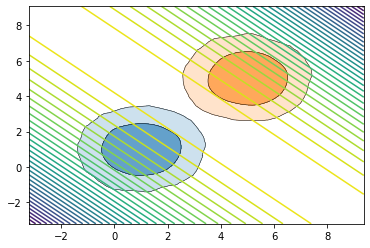

In [70]:
fig, axs = plt.subplots()
visualise_tension(fig, axs, tension, X0, X1)